# Analysis of Noise-Perturbed Student-Teacher Network

This notebook analyses the results from the grid search over noise levels in the feedforward noisy units experiment.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100

In [9]:
# Path to grid search results
grid_search_dir = Path("/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/activity-fitting/feedforward-noisy-units")

# Find all run directories
run_dirs = sorted([d for d in grid_search_dir.iterdir() if d.is_dir() and d.name.startswith("noise-fraction-")])
print(f"Found {len(run_dirs)} runs:")
for d in run_dirs:
    print(f"  {d.name}")

Found 10 runs:
  noise-fraction-0.05
  noise-fraction-0.10
  noise-fraction-0.15
  noise-fraction-0.20
  noise-fraction-0.25
  noise-fraction-0.30
  noise-fraction-0.35
  noise-fraction-0.40
  noise-fraction-0.45
  noise-fraction-0.50


In [10]:
# Extract noise levels and load final metrics from each run
results = []

for run_dir in run_dirs:
    # Extract noise fraction from directory name
    match = re.search(r'noise-fraction-([\d.]+)', run_dir.name)
    if match:
        noise_fraction = float(match.group(1))
    else:
        continue
    
    # Load training metrics
    metrics_path = run_dir / "training_metrics.csv"
    if not metrics_path.exists():
        print(f"Warning: {metrics_path} not found, skipping")
        continue
    
    df = pd.read_csv(metrics_path)
    
    # Get final row (last epoch)
    final_row = df.iloc[-1]
    
    results.append({
        'noise_fraction': noise_fraction,
        'final_epoch': final_row['epoch'],
        # Scaling factors - learned values
        'exc_to_exc_value': final_row['scaling_factors/excitatory_to_excitatory/value'],
        'exc_to_inh_value': final_row['scaling_factors/excitatory_to_inhibitory/value'],
        'inh_to_exc_value': final_row['scaling_factors/inhibitory_to_excitatory/value'],
        'inh_to_inh_value': final_row['scaling_factors/inhibitory_to_inhibitory/value'],
        'mitral_to_exc_value': final_row['scaling_factors/mitral_to_excitatory/value'],
        'mitral_to_inh_value': final_row['scaling_factors/mitral_to_inhibitory/value'],
        # Scaling factors - targets
        'exc_to_exc_target': final_row['scaling_factors/excitatory_to_excitatory/target'],
        'exc_to_inh_target': final_row['scaling_factors/excitatory_to_inhibitory/target'],
        'inh_to_exc_target': final_row['scaling_factors/inhibitory_to_excitatory/target'],
        'inh_to_inh_target': final_row['scaling_factors/inhibitory_to_inhibitory/target'],
        'mitral_to_exc_target': final_row['scaling_factors/mitral_to_excitatory/target'],
        'mitral_to_inh_target': final_row['scaling_factors/mitral_to_inhibitory/target'],
        # Loss
        'final_loss': final_row['total_loss'],
    })

results_df = pd.DataFrame(results).sort_values('noise_fraction').reset_index(drop=True)
print(f"\nLoaded results from {len(results_df)} runs")
results_df


Loaded results from 8 runs


,noise_fraction,final_epoch,exc_to_exc_value,exc_to_inh_value,inh_to_exc_value,inh_to_inh_value,mitral_to_exc_value,mitral_to_inh_value,exc_to_exc_target,exc_to_inh_target,inh_to_exc_target,inh_to_inh_target,mitral_to_exc_target,mitral_to_inh_target,final_loss
0,0.05,4000.0,0.699269,1.736303,1.645113,1.781052,1.324690,0.686567,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.041558
1,0.10,4000.0,0.688106,1.726734,1.618398,1.756541,1.316108,0.678363,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.081595
2,0.15,4000.0,0.675989,1.714437,1.589265,1.742010,1.301447,0.672277,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.121403
3,0.20,4000.0,0.663102,1.696950,1.563021,1.716137,1.285875,0.661379,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.162877
4,0.25,4000.0,0.649374,1.688114,1.535960,1.695806,1.267113,0.647431,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.206811
5,0.30,4000.0,0.631358,1.679428,1.502524,1.672545,1.242353,0.629895,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.253344
6,0.35,4000.0,0.614107,1.668648,1.463528,1.647540,1.204188,0.611310,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.302850
7,0.40,4000.0,0.593754,1.653162,1.415872,1.616135,1.158573,0.590549,0.708884,1.746334,1.672414,1.808238,1.332911,0.693316,0.354368


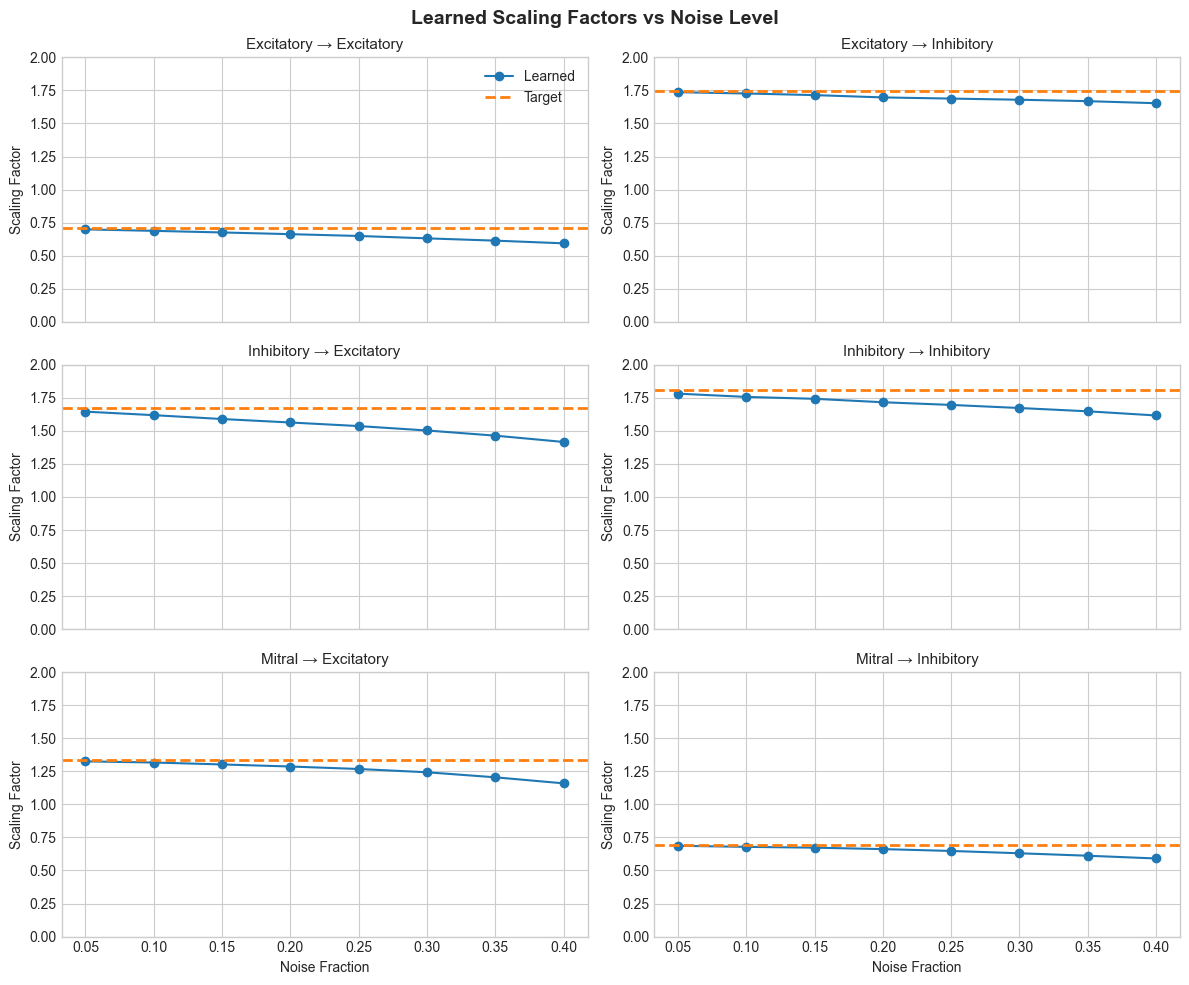

In [11]:
# Plot learned scaling factors vs noise level (3x2 subplot)
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)

scaling_factor_pairs = [
    ('exc_to_exc', 'Excitatory → Excitatory'),
    ('exc_to_inh', 'Excitatory → Inhibitory'),
    ('inh_to_exc', 'Inhibitory → Excitatory'),
    ('inh_to_inh', 'Inhibitory → Inhibitory'),
    ('mitral_to_exc', 'Mitral → Excitatory'),
    ('mitral_to_inh', 'Mitral → Inhibitory'),
]

noise_levels = results_df['noise_fraction'].values

for idx, (key, title) in enumerate(scaling_factor_pairs):
    ax = axes.flat[idx]
    
    # Get values and targets
    values = results_df[f'{key}_value'].values
    targets = results_df[f'{key}_target'].values
    
    # Plot learned values
    ax.plot(noise_levels, values, 'o-', color='C0', label='Learned', markersize=6)
    
    # Plot target (should be constant across noise levels)
    ax.axhline(y=targets[0], color='C1', linestyle='--', linewidth=2, label='Target')
    
    ax.set_title(title, fontsize=11)
    ax.set_ylabel('Scaling Factor')
    ax.set_ylim(0, 2)
    
    if idx >= 4:  # Bottom row
        ax.set_xlabel('Noise Fraction')
    
    if idx == 0:
        ax.legend(loc='best')

plt.suptitle('Learned Scaling Factors vs Noise Level', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [12]:
# Scatter plot of teacher vs perturbed weights for noise_frac = 0.4
noise_level_to_plot = 0.40
run_dir = grid_search_dir / f"noise-fraction-{noise_level_to_plot:.2f}"

# Load teacher weights (from symlinked input)
teacher_data = np.load(run_dir / "inputs" / "network_structure.npz")
teacher_ff_weights = teacher_data["feedforward_weights"]  # (1500, 5000)
teacher_rec_weights = teacher_data["recurrent_weights"]   # (5000, 5000)

# Concatenate to match the training script's format
teacher_weights = np.concatenate([teacher_ff_weights, teacher_rec_weights], axis=0)  # (6500, 5000)

# Load noise config to get seed
noise_config = np.load(run_dir / "targets" / "weight_noise_config.npz")
noise_frac = float(noise_config["noise_frac"])
seed = int(noise_config["seed"])

print(f"Noise fraction: {noise_frac}")
print(f"Seed: {seed}")
print(f"Teacher weights shape: {teacher_weights.shape}")

# Apply the same noise function used in training
def apply_weight_noise(weights, noise_frac, rng=None):
    """Apply unbiased multiplicative Gaussian noise to weights."""
    if rng is None:
        rng = np.random.default_rng()
    multiplier = 1 + noise_frac * rng.standard_normal(weights.shape)
    multiplier = np.clip(multiplier, 0, 2)
    return weights * multiplier

# Reconstruct the noisy weights
weight_noise_rng = np.random.default_rng(seed)
perturbed_weights = apply_weight_noise(teacher_weights, noise_frac, rng=weight_noise_rng)

print(f"Perturbed weights shape: {perturbed_weights.shape}")

Noise fraction: 0.4
Seed: 44
Teacher weights shape: (6500, 5000)
Perturbed weights shape: (6500, 5000)


Number of non-zero weights: 1,852,500
Subsampled to 50,000 points for plotting


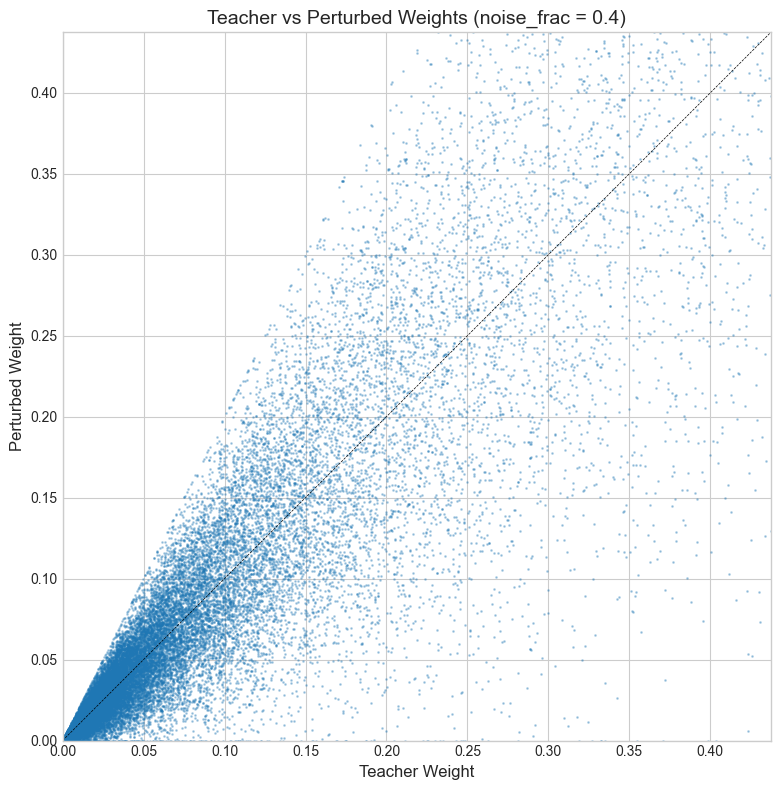


Weight statistics:
  Teacher mean: 0.1043, std: 0.3254
  Perturbed mean: 0.1040, std: 0.3412
  Correlation: 0.9159


In [13]:
# Scatter plot: Teacher vs Perturbed weights
# Only plot non-zero weights (where connections exist)
mask = teacher_weights != 0
teacher_flat = teacher_weights[mask]
perturbed_flat = perturbed_weights[mask]

print(f"Number of non-zero weights: {len(teacher_flat):,}")

# Subsample for plotting if too many points
max_points = 50000
if len(teacher_flat) > max_points:
    idx = np.random.choice(len(teacher_flat), max_points, replace=False)
    teacher_sample = teacher_flat[idx]
    perturbed_sample = perturbed_flat[idx]
    print(f"Subsampled to {max_points:,} points for plotting")
else:
    teacher_sample = teacher_flat
    perturbed_sample = perturbed_flat

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(teacher_sample, perturbed_sample, alpha=0.3, s=1, c='C0')

# Use 95th percentile for axis limits
upper_lim = np.percentile(np.concatenate([teacher_flat, perturbed_flat]), 95)
lims = [0, upper_lim]

ax.plot(lims, lims, 'k--', linewidth=0.5)

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Teacher Weight', fontsize=12)
ax.set_ylabel('Perturbed Weight', fontsize=12)
ax.set_title(f'Teacher vs Perturbed Weights (noise_frac = {noise_frac})', fontsize=14)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nWeight statistics:")
print(f"  Teacher mean: {teacher_flat.mean():.4f}, std: {teacher_flat.std():.4f}")
print(f"  Perturbed mean: {perturbed_flat.mean():.4f}, std: {perturbed_flat.std():.4f}")
print(f"  Correlation: {np.corrcoef(teacher_flat, perturbed_flat)[0,1]:.4f}")

Teacher mean firing rate: 1.168 Hz


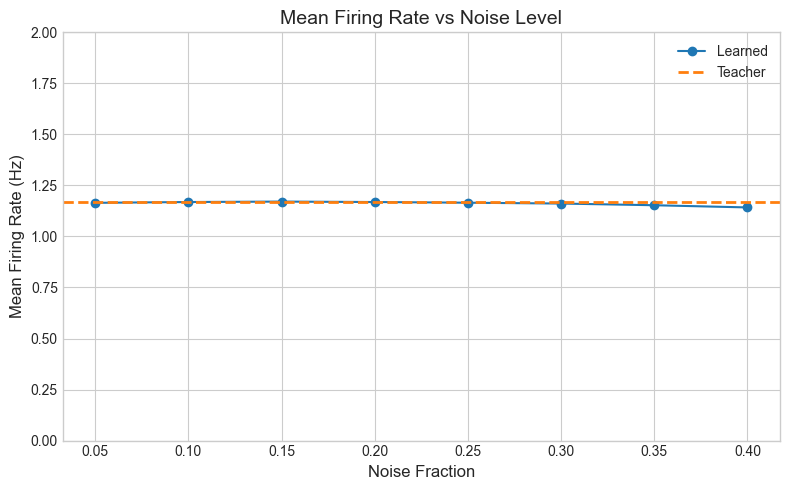

In [ ]:
# Plot mean firing rate vs noise level (with teacher reference)
import zarr

# Load teacher firing rate from the teacher spike data (symlinked in inputs folder)
teacher_zarr_path = grid_search_dir / "noise-fraction-0.05" / "inputs" / "spike_data.zarr"
teacher_zarr = zarr.open(store=teacher_zarr_path, mode='r')
teacher_spikes = teacher_zarr['output_spikes'][:]  # (batch, time, neurons)
dt = teacher_zarr.attrs['dt']  # ms

# Compute teacher mean firing rate in Hz
teacher_spike_count = teacher_spikes.sum()
total_time_s = teacher_spikes.shape[0] * teacher_spikes.shape[1] * dt / 1000.0
n_neurons = teacher_spikes.shape[2]
teacher_mean_rate = teacher_spike_count / (total_time_s * n_neurons)

print(f"Teacher mean firing rate: {teacher_mean_rate:.3f} Hz")

# Load learned firing rates from each run
results_with_fr = []

for run_dir in run_dirs:
    match = re.search(r'noise-fraction-([\d.]+)', run_dir.name)
    if match:
        noise_fraction = float(match.group(1))
    else:
        continue
    
    metrics_path = run_dir / "training_metrics.csv"
    if not metrics_path.exists():
        continue
    
    df = pd.read_csv(metrics_path)
    final_row = df.iloc[-1]
    
    results_with_fr.append({
        'noise_fraction': noise_fraction,
        'firing_rate_mean': final_row['firing_rate/mean'],
    })

fr_df = pd.DataFrame(results_with_fr).sort_values('noise_fraction').reset_index(drop=True)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(fr_df['noise_fraction'], fr_df['firing_rate_mean'], 'o-', color='C0', markersize=6, label='Learned')
ax.axhline(y=teacher_mean_rate, color='C1', linestyle='--', linewidth=2, label='Teacher')

ax.set_xlabel('Noise Fraction', fontsize=12)
ax.set_ylabel('Mean Firing Rate (Hz)', fontsize=12)
ax.set_title('Mean Firing Rate vs Noise Level', fontsize=14)
ax.set_ylim(0.5, 1.5)
ax.legend(loc='best')

plt.tight_layout()
plt.show()